<a href="https://colab.research.google.com/github/JimEverest/Deeplearning_Colab/blob/master/CatDog_V4(ResNet50)_WNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#For Tensorboard ext

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  print("TF2 Not working")
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard

TensorFlow 2.x selected.


#import

In [2]:
# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import datetime

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.initializers import glorot_uniform

import requests

Using TensorFlow backend.


In [3]:
tf.__version__

'2.1.0-rc1'

# W and B
[Quick Start](https://docs.wandb.com/quickstart)

In [0]:
# !pip install wandb

import wandb
from wandb.keras import WandbCallback
#bdc4ecd13b42f56d349429a38d217e9ed358809a

In [51]:
!wandb login

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: bdc4ecd13b42f56d349429a38d217e9ed358809a
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [69]:
# name — A display name for this run
# notes — A multiline string description associated with the run
# config — a dictionary-like object to set as initial config
# project — the name of the project to which this run will belong
# tags — a list of strings to associate with this run as tags
# dir — the path to a directory where artifacts will be written (default: ./wandb)
# entity — the team posting this run (default: your username or your default team)
# job_type — the type of job you are logging, e.g. eval, worker, ps (default: training)
# group — a string by which to group other runs; see Grouping
# reinit — whether to allow multiple calls to wandb.init in the same process (default: False)
# id — A unique id for this run primarily used for resuming; see Resuming, must be globally unique within a project
# resume — if set to True, the run auto resumes; can also be a unique string for manual resuming; see Resuming (default: False)
# anonymous — can be "allow", "never", or "must". This enables or explicitly disables anonymous logging. (default: None)
# force — whether to force a user to be logged into wandb when running a script (default: False)
# magic — (bool, dict, or str, optional): magic configuration as bool, dict, json string, yaml filename. If set to True will attempt to auto-instrument your script. (default: None)
# sync_tensorboard — A boolean indicating whether or not copy all tensorboard logs wandb; see Tensorboard (default: False)
# monitor_gym — A boolean indicating whether or not to log videos generated by OpenAI Gym; see Ray Tune (default: False)
# allow_val_change — whether to allow wandb.config values to change, by default we throw an exception if config values are overwritten. (default: False)

wandb.init( name = "CatDog-V4(ResNet50)_2" , project="CAT_DOG")
config = wandb.config

config.batch_size = 32
config.epochs=5

# Download/Split Data

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# don't have to exec each time...



def Download_file_2_Drive(url,path):
  file_url = url #"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
  file_name = file_url.split("/")[-1]
  r = requests.get(file_url, stream = True)  

  dest_path = path #"/content/drive/Shared drives/Share/Data/"
  os.makedirs(dest_path, exist_ok=True)
  dest_path = os.path.join(dest_path,file_name)
  with open(dest_path, "wb") as file:  
      for block in r.iter_content(chunk_size = 1024): 
          if block:  
              file.write(block)  

Download_file_2_Drive("https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip", "/content/drive/Shared drives/Share/Data/")

# Download_file_2_Drive("https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip", "/content/drive/My Drive/Data/")




In [18]:
!nvidia-smi

Wed Jan 15 05:14:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!cp "/content/drive/Shared drives/Share/Data/kagglecatsanddogs_3367a.zip" "/tmp/cats-and-dogs1.zip"
# !cp "/content/drive/My Drive/Data/kagglecatsanddogs_3367a.zip" "/tmp/cats-and-dogs1.zip"

In [0]:
# (Deprecated) Download to colab runtime tmp folder 

# If the URL doesn't work,   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# !wget --no-check-certificate \
#     "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
#     -O "/tmp/cats-and-dogs.zip"



In [0]:
local_zip = '/tmp/cats-and-dogs1.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


In [0]:
# Unzip to My Drive (Gdrive)

# local_zip = '/content/drive/My Drive/Data/kagglecatsanddogs_3367a.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/content/drive/My Drive/Data/')
# zip_ref.close()


In [22]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [0]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    #YOUR CODE GOES HERE
    os.mkdir("/tmp/cats-v-dogs")
    os.mkdir("/tmp/cats-v-dogs/training")
    os.mkdir("/tmp/cats-v-dogs/training/cats")
    os.mkdir("/tmp/cats-v-dogs/training/dogs")
    os.mkdir("/tmp/cats-v-dogs/testing")
    os.mkdir("/tmp/cats-v-dogs/testing/cats")
    os.mkdir("/tmp/cats-v-dogs/testing/dogs")
except OSError:
    pass

In [0]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
# YOUR CODE STARTS HERE
  files=os.listdir(SOURCE)
  flen= len(files)
  trainLen= int(flen * SPLIT_SIZE)
  rFiles=random.sample(files,len(files))
  trains=rFiles[:trainLen]
  tests= rFiles[trainLen:]
  for trF in trains:
    if(os.path.getsize(os.path.join(SOURCE,trF))>0):
      copyfile(os.path.join( SOURCE,trF),os.path.join( TRAINING,trF) )
  for teF in tests:
    if(os.path.getsize(os.path.join( SOURCE,teF))>0):
      copyfile(os.path.join( SOURCE,teF), os.path.join( TESTING,teF) )

# YOUR CODE ENDS HERE


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

In [4]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11249
11249
1251
1251


# Keras Model

In [0]:
LR = 3e-3
DECAY = 0.4
targetSize = (150,150)
Epochs = 50
input_data_shape = (150, 150, 3)

In [6]:
LR

0.003

#ResNet

A simple identity block of ResNet:
<img src="https://drive.google.com/uc?export=view&id=1FFOPEKHyXxVhSdw3soFIWYjnkq6dDVX7" style="width:650px;height:150px;">


A slightly **more powerful** version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this:
<img src="https://drive.google.com/uc?export=view&id=1-_vkZz0uOcyYQcWqaBgI_i2yeK-P-mom" style="width:650px;height:150px;"/>


`1ST component of main path:`

The first CONV2D has  `F1`  filters of shape `(1,1)` and a stride of (1,1). Its padding is `"valid"` and its name should be conv_name_base + '2a'. Use 0 as the seed for the random initialization.
The first BatchNorm is normalizing the 'channels' axis. Its name should be bn_name_base + '2a'.
Then apply the ReLU activation function. This has no name and no hyperparameters.


`2ND component of main path:`

The second CONV2D has  `F2`  filters of shape  `(f,f)`  and a stride of (1,1). Its padding is `"same"` and its name should be conv_name_base + '2b'. Use 0 as the seed for the random initialization.
The second BatchNorm is normalizing the 'channels' axis. Its name should be bn_name_base + '2b'.
Then apply the ReLU activation function. This has no name and no hyperparameters.


`3RD component of main path:`

The third CONV2D has  `F3`  filters of shape `(1,1)` and a stride of (1,1). Its padding is `"valid"` and its name should be conv_name_base + '2c'. Use 0 as the seed for the random initialization.
The third BatchNorm is normalizing the 'channels' axis. Its name should be bn_name_base + '2c'.
Note that there is no ReLU activation function in this component.

`Final step:`

The X_shortcut and the output from the 3rd layer X are added together.
Hint: The syntax will look something like Add()([var1,var2])
Then apply the ReLU activation function. This has no name and no hyperparameters.

In [0]:
"""
Implementation of the identity block as defined in Figure 3

Arguments:
X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
f -- integer, specifying the shape of the middle CONV's window for the main path
filters -- python list of integers, defining the number of filters in the CONV layers of the main path
stage -- integer, used to name the layers, depending on their position in the network
block -- string/character, used to name the layers, depending on their position in the network

Returns:
X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
"""
def identity_block(X, f, filters, stage, block ):
  conv_name_base="RES_CONV_" + str(stage) + "_" + str(block)
  bn_name_base="RES_BN_" + str(stage) + "_" + str(block)
  X_Short = X
  F1,F2,F3 = filters
  #1st
  x = layers.Conv2D( F1, (1,1), padding='valid',activation=None, kernel_initializer=glorot_uniform(seed=0), name = conv_name_base + '2a')(X)
  x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
  x = layers.Activation("relu")(x)

  #2nd
  x = layers.Conv2D( F2, (f,f), padding='same',activation=None, kernel_initializer=glorot_uniform(seed=0), name = conv_name_base + '2b')(x)
  x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
  x = layers.Activation("relu")(x)

  #3rd
  x = layers.Conv2D( F3, (1,1), padding='valid',activation=None, kernel_initializer=glorot_uniform(seed=0), name = conv_name_base + '2c')(X)
  x = layers.BatchNormalization(name=bn_name_base + '2c')(x)
 

  x = layers.Add()([x,X_Short])
  x = layers.Activation("relu")(x)
  return x

## 2.2 - The convolutional block

The ResNet "convolutional block" is the second block type. 

You can use this type of block `when the input and output dimensions don't match up`. 

The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="https://drive.google.com/uc?export=view&id=13z57SPRfNMooBdV_NZuWGLiqfbWQo8dH" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **Convolutional block** </center></caption>

* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.) 
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. 
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '2a'`. Use 0 as the `glorot_uniform` seed.
- The first BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same" and it's name should be `conv_name_base + '2b'`.  Use 0 as the `glorot_uniform` seed.
- The second BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and it's name should be `conv_name_base + '2c'`.  Use 0 as the `glorot_uniform` seed.
- The third BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2c'`. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '1'`.  Use 0 as the `glorot_uniform` seed.
- The BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '1'`. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 
    
**Exercise**: Implement the convolutional block. We have implemented the first component of the main path; you should implement the rest. As before, always use 0 as the seed for the random initialization, to ensure consistency with our grader.
- [Conv2D](https://keras.io/layers/convolutional/#conv2d)
- [BatchNormalization](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- For the activation, use:  `Activation('relu')(X)`
- [Add](https://keras.io/layers/merge/#add)

In [0]:
    # # Stage 1
    # X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    # X = BatchNormalization(axis=3, name='bn_conv1')(X)
    # X = Activation('relu')(X)
    # X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # # Stage 2
    # X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    # X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    # X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

In [0]:
"""
Implementation of the convolutional block as defined in Figure 4

Arguments:
X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
f -- integer, specifying the shape of the middle CONV's window for the main path
filters -- python list of integers, defining the number of filters in the CONV layers of the main path
stage -- integer, used to name the layers, depending on their position in the network
block -- string/character, used to name the layers, depending on their position in the network
s -- Integer, specifying the stride to be used

Returns:
X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
"""
def convolutional_block(X, f, filters,stage,block, s):
  conv_name_base = "Res_Conv_" + str(stage) + block + '_branch'
  bn_name_base = "BN_" + str(stage) + block + '_branch'
  F1,F2,F3 = filters
  X_short = X

  #1st
  # print("X       SHAPE       : " , X.shape)
  x = layers.Conv2D( F1, (1,1),strides=(s,s), padding='valid',activation=None, kernel_initializer=glorot_uniform(seed=0), name = conv_name_base + '2a')(X)
  # print("strides             : " , (s,s))
  # print("X2      SHAPE(AFTER): " , x.shape)
  x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
  x = layers.Activation("relu")(x)

  #2nd
  x = layers.Conv2D( F2, (f,f), strides=(1,1),padding='same',activation=None, kernel_initializer=glorot_uniform(seed=0), name = conv_name_base + '2b')(x)
  x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
  x = layers.Activation("relu")(x)
  # print("X3      SHAPE(AFTER): " , x.shape)
  #3rd
  x = layers.Conv2D( F3, (1,1), strides=(1,1),padding='valid',activation=None, kernel_initializer=glorot_uniform(seed=0), name = conv_name_base + '2c')(x)
  x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

  # print("X4      SHAPE(AFTER): " , x.shape)
  #Shortcut
  # print("X_short SHAPE(BEFOR): " , X_short.shape)
  X_short =layers.Conv2D( F3, (1,1),strides=(s,s), padding='valid',activation=None, kernel_initializer=glorot_uniform(seed=0), name = conv_name_base + '_st')(X_short)
  X_short = layers.BatchNormalization(name=bn_name_base + '_st')(X_short)

  # print("X_short SHAPE(AFTER): " , X_short.shape)
  # print("X5       SHAPE       : " , x.shape)
  # print("strides             : " , (s,s))
  # print("F3                  : " , F3)
  # print("----------------------------------")
  x = layers.Add()([x,X_short])
  x = layers.Activation("relu")(x)
  return x

3 - Building your first ResNet model (50 layers)
You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

![alt text](//github.com/priya-dwivedi/Deep-Learning/raw/090a6ff1f3236e6c216db6743af74f1728669e46/resnet_keras/images/resnet_kiank.png)

The details of this ResNet-50 model are:

Zero-padding pads the input with a pad of (3,3)
Stage 1:
The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
BatchNorm is applied to the channels axis of the input.
MaxPooling uses a (3,3) window and a (2,2) stride.
Stage 2:
The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
Stage 3:
The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
Stage 4:
The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
Stage 5:
The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
The 2 identity blocks use three set of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
The flatten doesn't have any hyperparameters or name.
The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be 'fc' + str(classes).

In [0]:
def ResNet50(input_size=(150,150,3),classes=2):
  """
  Implementation of the popular ResNet50 the following architecture:
  CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
  -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

  Arguments:
  input_shape -- shape of the images of the dataset
  classes -- integer, number of classes

  Returns:
  model -- a Model() instance in Keras
  """
  X_INPUT = layers.Input(input_size)
  X = layers.ZeroPadding2D(padding=(3,3))(X_INPUT)
  #1st Stage
  X = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X_INPUT)
  X = layers.BatchNormalization(axis=3, name='bn_conv1')(X)
  X = layers.Activation('relu')(X)
  X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

  #2nd Stage:
  X = convolutional_block(X, 3, [64,64,256],2,"a", s=1)
  X = identity_block(X, 3, [64,64,256], 2, "b" )
  X = identity_block(X, 3, [64,64,256], 2, "c" )

  #3rd Stage:
  X = convolutional_block(X, 3, [128,128,512],3,"a", s=2)
  X = identity_block(X, 3, [128,128,512], 3, "b" )
  X = identity_block(X, 3, [128,128,512], 3, "c" )
  X = identity_block(X, 3, [128,128,512], 3, "d" )


  #4th Stage:
  X = convolutional_block(X, 3, [256,256,1024],4,"a", s=2)
  X = identity_block(X, 3, [256,256,1024], 4, "b" )
  X = identity_block(X, 3, [256,256,1024], 4, "c" )
  X = identity_block(X, 3, [256,256,1024], 4, "d" )
  X = identity_block(X, 3, [256,256,1024], 4, "e" )
  X = identity_block(X, 3, [256,256,1024], 4, "f" )


  #5th Stage:
  X = convolutional_block(X, 3, [512,512,2048],5,"a", s=2)
  X = identity_block(X, 3, [512,512,2048], 5, "b" )
  X = identity_block(X, 3, [512,512,2048], 5, "c" )

  # POOLING
  X = layers.AveragePooling2D(name = 'avg_pooling')(X)
  X = layers.Flatten()(X)
  X = layers.Dense(512, activation = 'relu' , name = 'fc512', kernel_initializer = glorot_uniform(seed=0) ) (X)
  X = layers.Dense(1, activation = 'sigmoid' , name = 'fc' + str(classes), kernel_initializer = glorot_uniform(seed=0) ) (X)

  model = keras.Model(inputs = X_INPUT, outputs = X, name = "ResNet50")
  return model

In [0]:
model = ResNet50(input_size=(150,150,3),classes=2)

![demo](https://drive.google.com/uc?export=view&id=1qlPeM2pXOJ-ItGGt6Cn6oHy1aEBDCEwK)

# Simple resnet

In [0]:
def resnet_block(input_data,filters,conv_size):
  x = layers.Conv2D(filters,conv_size,activation='relu',padding='same')(input_data)
  x = layers.BatchNormalization(momentum=0.9)(x)
  x = layers.Conv2D(filters,conv_size,activation=None,padding='same')(x)
  x = layers.BatchNormalization(momentum=0.9)(x)
  x = layers.Add()([x,input_data])
  x = layers.Activation('relu')(x)
  return x

# def ResNet(num_res_net_blocks ,input_size, filters, conv_size):
#   inputs = layers.Input(shape=input_size)
#   x = layers.Conv2D(32, (3,3),activation=None )(inputs)
#   x = layers.Conv2D(64, (3,3), activation='relu')(x)
#   x = layers.Conv2D(128, (3,3), activation='relu')(x)

#   #for i in range(num_res_net_blocks):
#   x = resnet_block(x,filters,conv_size)

    
#   x = layers.Conv2D(64, (3,3), activation='relu')(x)
#   x = layers.MaxPooling2D()(x)

#   x = layers.Flatten()(x)
#   x = layers.Dense(256, activation='relu')(x)
#   # x = layers.Dense(128, activation='relu')(x)
#   # x = layers.Dropout(0.5)(x)
#   outputs = layers.Dense(1, activation='sigmoid')(x)
#   model = keras.Model(inputs,outputs)
#   return model

In [0]:
model = ResNet(1,input_size=(150,150,3),filters=128,conv_size=(3,3))

#Simple RenNet Model (Functional API Model define)

In [0]:
def reglar_CNN_block(input_data,filters,conv_size,strides=(1, 1), kernel_initializer=glorot_uniform(seed=0), use_dropout=False, dropout=0.2):
  x = layers.Conv2D(filters, conv_size,activation=None,strides=strides,kernel_initializer=kernel_initializer )(input_data)
  x = layers.BatchNormalization(momentum=0.9)(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPool2D()(x)
  if use_dropout:
    x = layers.Dropout(dropout)(x)
  return x

In [0]:
# Plain NN (Functional Model)
def SimpleRes(input_size):
  inputs = layers.Input(shape=input_size)
  x = reglar_CNN_block(inputs,32,(3,3))
  # x = reglar_CNN_block(x,32,(3,3))
  x = reglar_CNN_block(x,64,(3,3))
  x = reglar_CNN_block(x,128,(3,3))

  # x = layers.Conv2D(16, (3,3),activation=None )(inputs)
  # x = layers.BatchNormalization(momentum=0.9)(x)
  # x = layers.Activation('relu')(x)
  # x = layers.MaxPool2D()(x)
  # x = layers.Dropout(0.2)(x)

  # x = layers.Conv2D(32, (3,3),activation=None )(x)
  # x = layers.BatchNormalization(momentum=0.9)(x)
  # x = layers.Activation('relu')(x)
  # x = layers.MaxPool2D()(x)
  # x = layers.Dropout(0.2)(x)

  # x = layers.Conv2D(64, (3,3),activation=None )(x)
  # x = layers.BatchNormalization(momentum=0.9)(x)
  # x = layers.Activation('relu')(x)
  # x = layers.MaxPool2D()(x)
  # x = layers.Dropout(0.2)(x)

  # x = layers.Conv2D(128, (3,3),activation=None )(x)
  # x = layers.BatchNormalization(momentum=0.9)(x)
  # x = layers.Activation('relu')(x)
  # x = layers.MaxPool2D()(x)
  # x = layers.Dropout(0.2)(x)

  x = resnet_block(x,128,(3,3))
  x = resnet_block(x,128,(3,3))
  x = resnet_block(x,128,(3,3))
  x = resnet_block(x,128,(3,3))


  x = resnet_block(x,128,(3,3))
  x = resnet_block(x,128,(3,3))
  x = resnet_block(x,128,(3,3))
  x = resnet_block(x,128,(3,3))
  x = resnet_block(x,128,(3,3))
  x = resnet_block(x,128,(3,3))
  # x = layers.Conv2D(256, (3,3),activation=None )(x)
  # x = layers.BatchNormalization(momentum=0.9)(x)
  # x = layers.Activation('relu')(x)
  x = layers.MaxPool2D()(x)
  x = layers.Dropout(0.2)(x)


  x = layers.Flatten()(x)
  x = layers.Dense(512, activation=None)(x)
  x = layers.BatchNormalization(momentum=0.9)(x)
  x = layers.Activation('relu')(x)
  x = layers.Dropout(0.4)(x)
  outputs = layers.Dense(1, activation='sigmoid')(x)
  mod = keras.Model(inputs,outputs)
  return mod

In [0]:
model = PlainNet((150,150,3))

In [0]:
model = SimpleRes((150,150,3))  

# Sequential Model

In [0]:
# WITH BatchNormalization (Sequential Model)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D( 16,(3,3),activation=None,input_shape=(150,150,3)),
  tf.keras.layers.BatchNormalization(momentum=0.9),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D( 32,(3,3),activation=None),
  tf.keras.layers.BatchNormalization(momentum=0.9),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D( 64,(3,3),activation=None),
  tf.keras.layers.BatchNormalization(momentum=0.9),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(128,(3,3),activation=None),
  tf.keras.layers.BatchNormalization(momentum=0.9),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(256,(3,3),activation=None),
  tf.keras.layers.BatchNormalization(momentum=0.9),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512,activation=None),
  tf.keras.layers.BatchNormalization(momentum=0.9),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1,activation="sigmoid")
# YOUR CODE HERE
])


# Compile Model

In [0]:

# model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
model.compile(optimizer=Adam(lr=LR), loss='binary_crossentropy', metrics=['acc'])

# Generator

In [73]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
    )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,batch_size=64,target_size=targetSize,class_mode="binary")

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = train_datagen.flow_from_directory(VALIDATION_DIR,batch_size=64,target_size=targetSize,class_mode="binary")



# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22496 images belonging to 2 classes.
Found 2502 images belonging to 2 classes.


In [0]:
import warnings
warnings.filterwarnings('ignore')

# TensorBoard Launch

[link](https://www.dlology.com/blog/how-to-run-tensorboard-in-jupyter-notebook/)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
LOG_DIR = '/content/drive/My Drive/logs/cat_dog/'
try:
    # os.mkdir(LOG_DIR)
    os.makedirs(LOG_DIR, exist_ok=True)
except OSError:
    print("Path Error")
    pass


In [0]:
#TEST
!cd /content/drive/"My Drive"/logs/cat_dog/

In [0]:
!ls

drive  sample_data


In [0]:
# start hera
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
# path with '' ---> (for rm & tb cmd)
regDir = LOG_DIR.replace("My Drive","'My Drive'")
regDir

NameError: ignored

In [0]:
# DELETE ALL LOGS EXISTED!!!
# !rm -rf {regDir}  

In [0]:
# logs_base_dir = "/content/drive/Shared drives/Share/logs/cat_dog/"
# # os.makedirs(logs_base_dir, exist_ok=True)

# # %tensorboard --logdir {logs_base_dir}
%tensorboard --logdir  {regDir}
# %tensorboard --logdir ./logs

In [0]:

# _logdir = os.path.join(LOG_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(_logdir, histogram_freq=1)    
# print(_logdir)

# Tensorboard display alternative way

In [0]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir /content/drive/My Drive/logs/cat_dog/ (started 0:00:35 ago; pid 420)


In [0]:
# Control TensorBoard display. If no port is provided, 
# the most recently launched TensorBoard is used
notebook.display(port=6006, height=1000) 

# Callbacks & Train

[callbacks](https://keras.io/zh/callbacks/)

In [0]:
Model_DIR = '/content/drive/My Drive/models/cat_dog/'
os.makedirs(Model_DIR,exist_ok=True)

In [49]:


# tensorboard_callback
# log_dir=LOG_DIR + datetime.datetime.now().strftime("%Y%m%d%H%M%S") + "-DOGCAT-" + "_lr-%.4f_decay-%.2f/"%(LR,DECAY)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# print(log_dir)
 
#filepath 可以包括命名格式选项，可以由 epoch 的值和 logs 的键（由 on_epoch_end 参数传递）来填充。
#例如：如果 filepath 是 weights.{epoch:02d}-{val_loss:.2f}.hdf5， 那么模型被保存的的文件名就会有训练轮数和验证损失。

#monitor: 被监测的数据。
#verbose: 详细信息模式，0 或者 1 。
#save_best_only: 如果 save_best_only=True， 被监测数据的最佳模型就不会被覆盖。
#mode: {auto, min, max} 的其中之一。 如果 save_best_only=True，那么是否覆盖保存文件的决定就取决于被监测数据的最大或者最小值。 对于 val_acc，模式就会是 max，而对于 val_loss，模式就需要是 min，等等。 在 auto 模式中，方向会自动从被监测的数据的名字中判断出来。
#save_weights_only: 如果 True，那么只有模型的权重会被保存 (model.save_weights(filepath))， 否则的话，整个模型会被保存 (model.save(filepath))。
# keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
checkpoint = ModelCheckpoint(Model_DIR + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                             monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=DECAY, patience=4, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1)

In [76]:
# Remember to add callbacks here...

history = model.fit_generator(train_generator,
                              epochs=Epochs,
                              verbose=1,
                              validation_data=validation_generator, 
                              # callbacks=[tensorboard_callback,checkpoint,reduce_lr,early_stopping])
                              callbacks=[WandbCallback(),checkpoint,reduce_lr,early_stopping])

# The expectation here is that the model will train, and that accuracy will be > 95% on both training and validation
# i.e. acc:A1 and val_acc:A2 will be visible, and both A1 and A2 will be > .9

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 352 steps, validate for 40 steps
Epoch 1/50
352/352 [==============================] - 297s 843ms/step - loss: 1.0865 - acc: 0.5964 - val_loss: 0.7939 - val_acc: 0.5168
Epoch 2/50
352/352 [==============================] - 287s 816ms/step - loss: 0.6045 - acc: 0.6715 - val_loss: 0.6033 - val_acc: 0.6595
Epoch 3/50
352/352 [==============================] - 286s 813ms/step - loss: 0.5749 - acc: 0.6983 - val_loss: 0.5857 - val_acc: 0.6990
Epoch 4/50
352/352 [==============================] - 284s 806ms/step - loss: 0.5546 - acc: 0.7144 - val_loss: 0.5923 - val_acc: 0.6910
Epoch 5/50
352/352 [==============================] - 283s 804ms/step - loss: 0.5406 - acc: 0.7267 - val_loss: 0.7677 - val_acc: 0.5911
Epoch 6/50
352/352 [==============================] - 283s 804ms/step - loss: 0.5153 - acc: 0.7449 - val_loss: 1.2862 - val_acc: 0.5532
Epoch 7/50
351/352 [============================>.] - ETA: 0s - loss: 0.4928 - acc: 0.7603


KeyboardInterrupt: ignored

# Plot acc,loss

Text(0.5, 1.0, 'Training and validation loss')

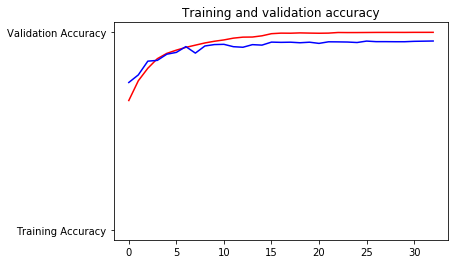

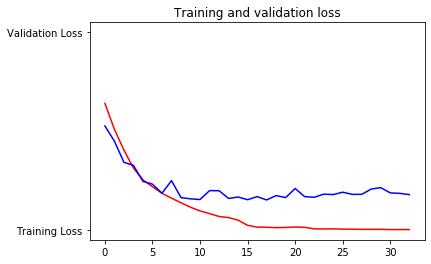

In [0]:
# PLOT LOSS AND ACCURACY 
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

#load Model

In [53]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 72, 72, 64)   9472        input_18[0][0]                   
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 72, 72, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 72, 72, 64)   0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [0]:
LOG_DIR

'/content/drive/My Drive/logs/cat_dog/'

In [0]:
model.load_weights(LOG_DIR + 'ep036-loss0.119-val_loss0.129.h5')

# Predict

## REMEMBER TO ADD (1/255) !!!

In [0]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img) * (1/255)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving cat1.jpg to cat1 (2).jpg
Saving cat2.jpg to cat2 (1).jpg
Saving cat3.jpg to cat3 (2).jpg
Saving cat4.jpg to cat4 (4).jpg
Saving cat5.jpg to cat5 (1).jpg
Saving cat6.jpg to cat6 (3).jpg
Saving cat7.jpg to cat7 (1).jpg
Saving cat8.jpg to cat8 (1).jpg
Saving dog1.jpg to dog1 (1).jpg
Saving dog2.jpg to dog2 (1).jpg
Saving dog3.jpg to dog3 (2).jpg
Saving dog4.jpg to dog4 (2).jpg
Saving dog5.jpg to dog5 (1).jpg
Saving dog6.jpg to dog6 (1).jpg
Saving dog7.jpg to dog7 (1).jpg
Saving dog8.jpg to dog8 (1).jpg
[[0.76533794]]
[0.76533794]
cat1.jpg is a dog
[[0.19487248]]
[0.19487248]
cat2.jpg is a cat
[[0.0174355]]
[0.0174355]
cat3.jpg is a cat
[[0.00066156]]
[0.00066156]
cat4.jpg is a cat
[[0.00593456]]
[0.00593456]
cat5.jpg is a cat
[[0.02451831]]
[0.02451831]
cat6.jpg is a cat
[[0.2138831]]
[0.2138831]
cat7.jpg is a cat
[[0.4728716]]
[0.4728716]
cat8.jpg is a cat
[[1.]]
[1.]
dog1.jpg is a dog
[[0.9999894]]
[0.9999894]
dog2.jpg is a dog
[[0.3093538]]
[0.3093538]
dog3.jpg is a cat
[[0.9997

In [0]:
del model

In [0]:
# WITH BatchNormalization
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D( 16,(3,3),activation=None,input_shape=(300,300,3)),
  tf.keras.layers.BatchNormalization(momentum=0.9),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPool2D(),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D( 32,(3,3),activation=None),
  tf.keras.layers.BatchNormalization(momentum=0.9),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPool2D(),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D( 64,(3,3),activation=None),
  tf.keras.layers.BatchNormalization(momentum=0.9),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPool2D(),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(128,(3,3),activation=None),
  tf.keras.layers.BatchNormalization(momentum=0.9),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(256,(3,3),activation=None),
  tf.keras.layers.BatchNormalization(momentum=0.9),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPool2D(),

  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512,activation=None),
  tf.keras.layers.BatchNormalization(momentum=0.9),
  tf.keras.layers.Activation('relu'),
  # tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1,activation="sigmoid")
# YOUR CODE HERE
])


In [0]:
model.load_weights(LOG_DIR + 'ep036-loss0.119-val_loss0.129.h5')

In [0]:
model.compile(optimizer=Adam(lr=LR), loss='binary_crossentropy', metrics=['acc'])